# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add EllipticEulerianDiffusionBarriers folder to current working path
sys.path.append(parent_directory+"/demos/DiffusionBarriers/EllipticEulerianDiffusionBarriers")

Wall time: 0 ns


# Overview

In the following notebook we extract elliptic Eulerian diffusion barriers (elliptic EDB) from a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'.
<br />
2. Define computational parameters (such as the number of cores) and variables.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data.
 <br />
5. Elliptic Eulerian diffusion barriers (EDB):

    * Compute gradient of velocity field $ \mathbf{\nabla v}(\mathbf{x}. t) $ over meshgrid using an auxiliary meshgrid. 
    <br />
    * Compute rate of strain: 
    
    \begin{equation} \mathbf{S}(\mathbf{x}, t) = \begin{pmatrix} S_{11} & S_{12} \\ S_{11} & S_{12} \end{pmatrix} = \dfrac{1}{2}(\mathbf{v}(\mathbf{x}, t)+\mathbf{v}(\mathbf{x}, t)^T) \end{equation}
    <br />
    * Uniform eulerian diffusion barriers satisfy
    
    \begin{equation}
    \langle \mathbf{x}', 2\mathbf{S}(\mathbf{x}, t)- \mathcal{T}_0 \mathbf{I})
    \mathbf{x}') = 0
    \end{equation}
    
    Elliptic Eulerian diffusion barriers are closed null geodesics of the one-parameter family of Lorentzian
    metrics:
    
    \begin{equation}
    \mathbf{\hat{E}}_{\mathcal{T}_0}(\mathbf{x}) = 2\mathbf{S}(\mathbf{x}, t)-
    \mathcal{T}_0\mathbf{I},
    \end{equation} on the spatial domain satisfying $ \lambda_1 \leq \mathcal{T}_0 \leq
    \lambda_2 $, where $ \lambda_1, \lambda_2 $ are respectively the minimum and maximum eigenvalues of $ 2\mathbf{S}(\mathbf{x}, t) $.
    <br />
    
    Closed null geodesics are closed curves of the system of ODE:
    
    \begin{align*}
    \dfrac{d \mathbf{x}}{ds} &= \mathbf{e}_{\phi}(s) = \begin{pmatrix} \cos(\phi(s)) \\ \sin(\phi(s)) \end{pmatrix} \\
    \dfrac{d \phi}{ds} &= - \dfrac{\langle \mathbf{e}_{\phi}(s), (\nabla_x A(\mathbf{x}) \mathbf{e}_{\phi}(s)) \mathbf{e}_{\phi}(s) \rangle}{2 \langle \mathbf{e}_{\phi}, R^T A(\mathbf{x}) \mathbf{e}_{\phi}(s)}, 
    \end{align*} where $ R = \begin{pmatrix} 0 && -1 \\ 1 && 0\end{pmatrix} $.
    
    $  \dfrac{d \phi}{ds} $ depends both on $ \mathbf{x} $ and on $ \phi $ and can be evaluated through interpolation by first computing $ \nabla_x \mathbf{A}(\mathbf{x}) = \nabla_x \mathbf{S}(\mathbf{x}, t) $ over the meshgrid.
    
    The set of initial conditions is given by:
    \begin{equation}
    (\mathbf{x}_0, \phi_0)_{\mathcal{T}_0} = \lbrace (\mathbf{x}(\mathcal{T}_0, \phi = 0), 0) \in V: 2S^{11}(\mathbf{x}, t) - \mathcal{T}_0 = 0 \rbrace
    \end{equation}
    
    Furthermore the domain of existence of the ODE is restricted to points $ \mathbf{x}, \phi $ where:
    
    \begin{equation}
    \sin(2\phi)[S^{22}(\mathbf{x})-S^{11}(\mathbf{x})]+2\cos(2\phi)S^{12}(\mathbf{x}) \neq 0
    \end{equation}

# Import Data

We start by importing the AVISO-data from the file 'AVISO.mat' stored in the folder 'data'.

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

Wall time: 943 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 18

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## meshgrid
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which we consider the dynamical system.

In [4]:
%%time
# Time
t_OECS = 0

# store time in array
time = np.array([t_OECS])

# domain boundary (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -24

# make sure that the spatio-temporal you defined are within the domain of the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and np.min(time_data) <= t_OECS <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"

# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Wall time: 998 µs


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time_data, method = "cubic")

Wall time: 369 ms


#  Rate of strain tensor

The rate of strain tensor $ S(\mathbf{x}_0, t) $ at time $ t $ is computed by iterating over meshgrid. The rate of strain tensor at point $ \mathbf{x}_0 $ at time $ t $ is computed from the gradient of the velocity field by using an auxiliary meshgrid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{5}, \dfrac{1}{10}] $. The computations are parallelized.

In [6]:
%%time
# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import gradient of velocity function
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Import Rate of Strain function
from ipynb.fs.defs.RateStrain import RateStrain

# Import package which checks particle location
from ipynb.fs.defs.check_location import check_location

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/5, 1/10]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

def parallel_S(i):
    
    S_parallel = np.zeros((X_domain.shape[1], 2, 2))*np.nan
    
    for j in range(S_parallel.shape[0]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
  
        # only compute rate of strain for particles in region where velocity field is defined
        if check_location(X, Y, defined_domain, x)[0] == "IN":
        
            # Compute gradient of velocity
            grad_vel = gradient_velocity(t_OECS, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
            
            # Compute rate of strain at 'x'
            S_parallel[j, :, :] = RateStrain(grad_vel)
    
    return S_parallel

# Compute S with parallel computing
S = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_S)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/401 [00:00<?, ?it/s]

Wall time: 14.5 s


# Compute Tensorfield

In [7]:
# Import (cubic) RectBivariateSpline from scipy
from scipy.interpolate import RectBivariateSpline as RBS
        
# Compute gradients of elements of rate of strain tensor
S11 = S[:,:,0,0].copy()
S12 = S[:,:,0,1].copy()
S22 = S[:,:,1,1].copy()
    
# Interpolate elements of rate of strain tensor (per default: linear)
interp_S11 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(S11, nan = 0.0), kx = 1, ky = 1)
interp_S12 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(S12, nan = 0.0), kx = 1, ky = 1)
interp_S22 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(S22, nan = 0.0), kx = 1, ky = 1)

# Initialize arrays
S11x = np.zeros((S.shape[0], S.shape[1]))*np.nan
S11y = np.zeros((S.shape[0], S.shape[1]))*np.nan
S12x = np.zeros((S.shape[0], S.shape[1]))*np.nan
S12y = np.zeros((S.shape[0], S.shape[1]))*np.nan
S22x = np.zeros((S.shape[0], S.shape[1]))*np.nan
S22y = np.zeros((S.shape[0], S.shape[1]))*np.nan
    
# Define auxilary meshgrid
rho_x = aux_grid[0]/2
rho_y = aux_grid[1]/2
        
#iterate over meshgrid
for i in range(X_domain.shape[0]):
        
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute derivatives using auxiliary grid and finite-differencing
        S11x[i, j] = (interp_S11(x[1], x[0]+rho_x)[0][0]-interp_S11(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S11y[i, j] = (interp_S11(x[1]+rho_y, x[0])[0][0]-interp_S11(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        S12x[i, j] = (interp_S12(x[1], x[0]+rho_x)[0][0]-interp_S12(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S12y[i, j] = (interp_S12(x[1]+rho_y, x[0])[0][0]-interp_S12(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
            
        S22x[i, j] = (interp_S22(x[1], x[0]+rho_x)[0][0]-interp_S22(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S22y[i, j] = (interp_S22(x[1]+rho_y, x[0])[0][0]-interp_S22(x[1]-rho_y, x[0])[0][0])/(2*rho_y)

# Interpolate $ \dot{\phi}(x, y, \phi)$ 

In [8]:
%%time
from ipynb.fs.defs.phi_prime import _phi_prime

# Interpolant phi_phrime, interpolant indicating domain of existence (= denominator of phi_prime)
interp_phi_prime, interp_DOE = _phi_prime(X_domain, Y_domain, S11, S12, S22, S11x, S11y, S12x, S12y, S22x, S22y)

Wall time: 1.64 s


# Elliptic Eulerian diffusion barriers

In [9]:
%%time
# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Import function to extract closed null geodesics
from ipynb.fs.defs.closed_null_geodesics import closed_null_geodesics

# extract elliptic EDB from closed null geodesics
from ipynb.fs.defs.elliptic_DB import elliptic_DB

# define T0 range
T0_min = -0.01
T0_max = 0.01
n_T0 = Ncores
T0_range = np.linspace(T0_min, T0_max, n_T0)

# threshold distance between starting and return point of trajectory
d_threshold = 0.01

# compute elliptic EDB
def compute_elliptic_EDB(T0):
    
    # Define list storing x, y coordinates of elliptic EDB
    x_elliptic, y_elliptic = [], []
    
    # Find all closed null geodesics
    closed_NG, init_T0 = closed_null_geodesics(X_domain, Y_domain, T0, interp_phi_prime, d_threshold, S11, defined_domain, interp_DOE)
    
    # Extract elliptic EDB
    x_elliptic, y_elliptic = elliptic_DB(closed_NG)
        
    return [x_elliptic, y_elliptic, init_T0]
        
# compute elliptic EDB with parallel computing
Elliptic_EDB = Parallel(n_jobs=Ncores, verbose = 0)(delayed(compute_elliptic_EDB)(i) for i in T0_range)

Wall time: 41.3 s


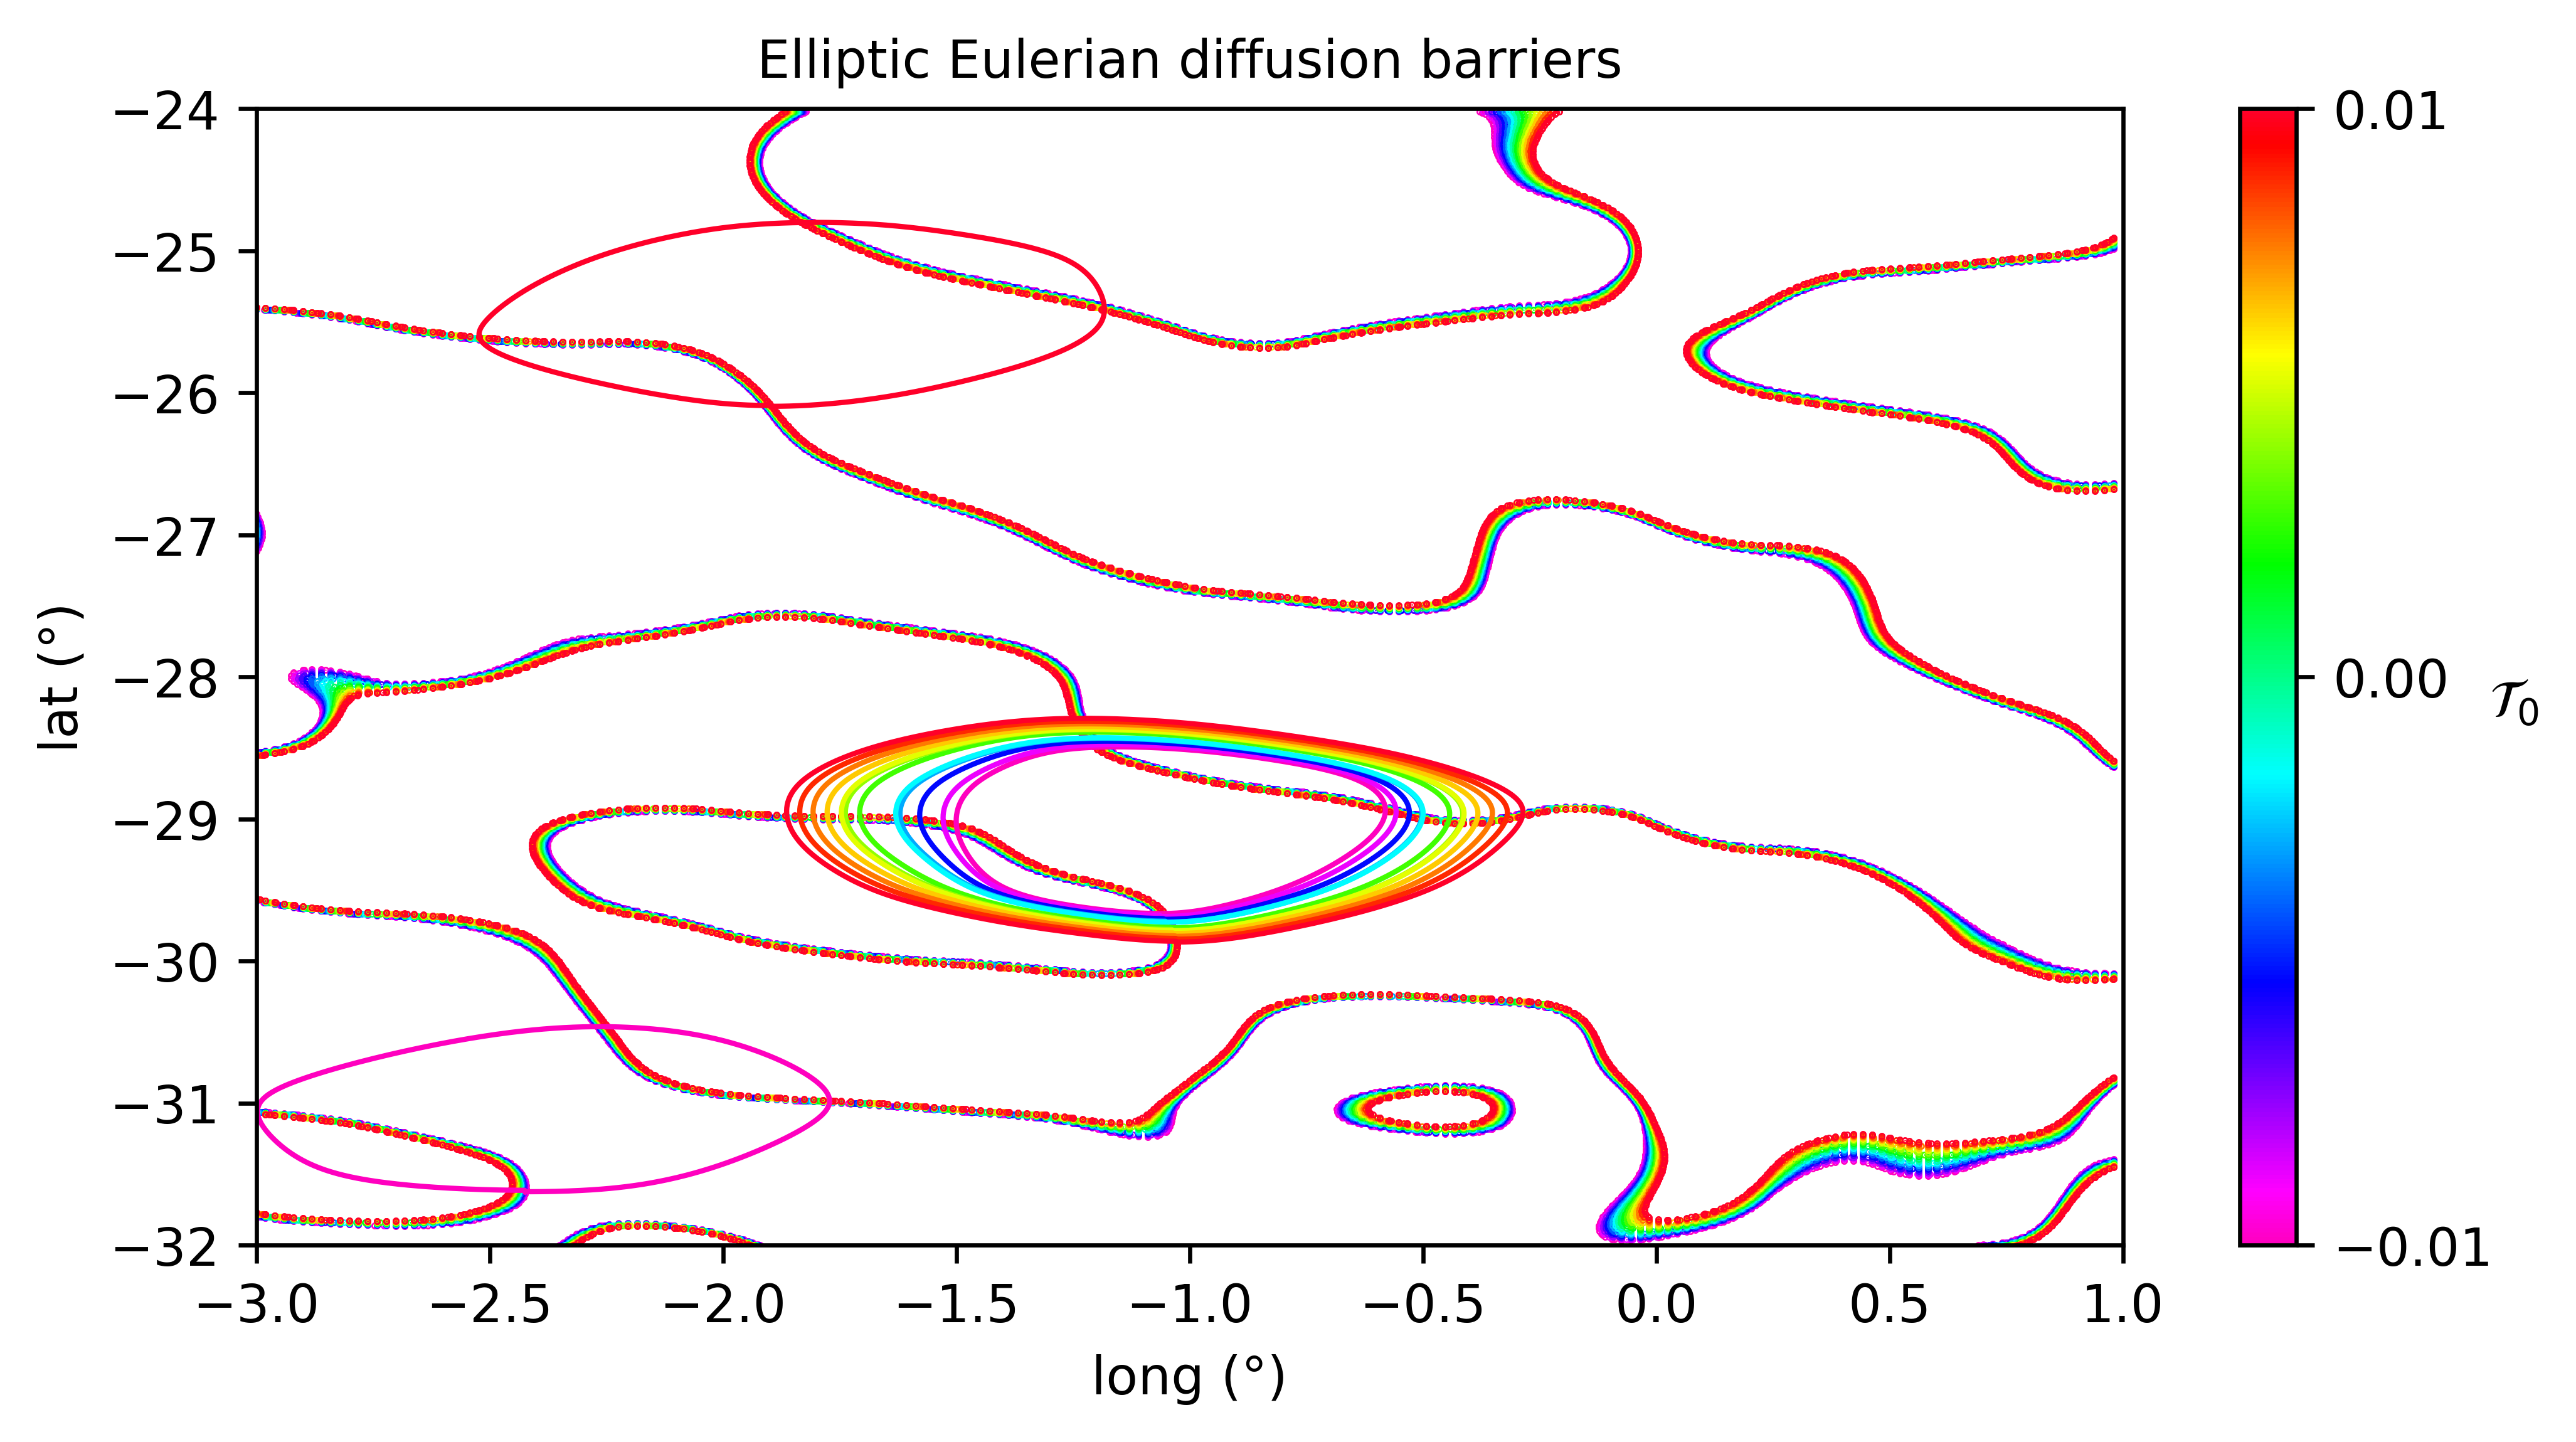

Wall time: 1.4 s


In [10]:
%%time
######################################## Plot elliptic Eulerian diffusion barriers ########################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=T0_range.min(), vmax=T0_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# Iterate over all elliptic EDB and plot
for i in range(len(Elliptic_EDB)):
    
    # Plot initial conditions
    ax.scatter(Elliptic_EDB[i][2][0], Elliptic_EDB[i][2][1], color=cmap.to_rgba(T0_range[i]), s = 0.1)
    
    # Plot elliptic EDB
    if Elliptic_EDB[i][0] is not None:
        for j in range(len(Elliptic_EDB[i][0])):
            if Elliptic_EDB[i][0][j] is not None:
                ax.plot(Elliptic_EDB[i][0][j], Elliptic_EDB[i][1][j], c=cmap.to_rgba(T0_range[i]), linewidth = 1)

# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[T0_range.min(), 0, T0_range.max()])
cbar.ax.set_ylabel(r'$ \mathcal{T}_0 $', rotation = 0, fontsize = 10)

# Title
ax.set_title("Elliptic Eulerian diffusion barriers", fontsize = 10)
plt.show();

The colored (closed) curves indicate elliptic Eulerian diffusion barriers with constant transport density $ \mathcal{T}_0 $. The colored dots indicate the initial conditions depending on $ \mathcal{T}_0 $.

# References

[1] Haller, G., Karrasch, D., & Kogelbauer, F. (2018). Material barriers to diffusive and stochastic transport. Proceedings of the National Academy of Sciences, 115(37), 9074-9079.